In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
system = {
    'duration': 9999.0, 
    'resolution': 1.0,
    'species': [
        ('i', 0),
        ('I', 0),
        ('a', 0), 
        ('A', 0),
        ('C', 0),
        ('CC', 0),
        ('t', 0), 
        ('T', 0), 
        ('TT', 0),
    ],
    'reactions': [
        ('sigma_i', (), ((1, 'i'), )), 
        ('alpha_i', ((1, 'i'), ), ((1, 'i'), (1, 'I'))), 
        ('F_i', ((1, 'i'), ), ()), 
        ('Gamma', ((1, 'i'), ), ()), 
        ('G_I', ((1, 'I'), ), ()), 
        ('Gamma', ((1, 'I'), ), ()), 

        ('lambda_ta', (), ((1, 't'), (1, 'a'))), 
        ('alpha_a', ((1, 'a'), ), ((1, 'a'), (1, 'A'))), 
        ('alpha_t', ((1, 't'), ), ((1, 't'), (1, 'T'))), 
        ('F_a', ((1, 'a'), ), ()), 
        ('F_t', ((1, 't'), ), ()), 
        ('Gamma', ((1, 'a'), ), ()), 
        ('Gamma', ((1, 't'), ), ()), 
        ('G_A', ((1, 'A'), ), ()), 
        ('G_T', ((1, 'T'), ), ()), 
        ('G_T', ((1, 'TT'), ), ((1, 'T'), )), 
        ('Gamma', ((1, 'A'), ), ()), 
        ('Gamma', ((1, 'T'), ), ()), 

        ('k_C', ((2, 'T'), ), ((1, 'TT'), )), 
        ('k_C', ((1, 'TT'), (1, 'A')), ((1, 'C'), )), 
        ('k_C', ((2, 'C'), ), ((1, 'CC'), )), 
        ('G_C', ((1, 'C'), ), ((1, 'TT'), )), 
        ('G_C', ((1, 'CC'), ), ((1, 'TT'), (1, 'C'))), 
        ('Gamma', ((1, 'TT'), ), ()), 
        ('Gamma', ((1, 'C'), ), ()), 
        ('Gamma', ((1, 'CC'), ), ()), 
        
    ], 
    'variables': [
        ('sigma_i', 20.0), 
        ('alpha_i', 200.0), 
        ('mu_i', 5.0), 
        ('sigma', 20.0), 
        ('k_0', 0.05), 
        ('alpha_t', 200.0), 
        ('nu', 1.6), 
        ('k_C', 1000.0), 
        ('mu_ta', 5.0), 
        ('f_T', 20.0), # change to beta_T
        ('omega', 0.2), 
        ('delta', 1.5),
        ('mu', 100.0), 
        ('epsilon', 0.01), 
        ('kappa', 1.0),
        ('kappa_I', 1.0), 
        ('kappa_A', 1.0), 
        ('kappa_C', 0.1), 
        ('kappa_T', 0.0), 
        ('gamma', 1.0), 
        ('phi', 1.0), 
        ('b_c', 0.25), # change to beta_g
    ], 
    'functions': [
        ('alpha_a', 'alpha_t * nu'), 
        ('T_free', 'T + TT'), 
        ('lambda_ta', 'sigma / (1 + k_0 * (A + C + CC))'), 
        ('F_t', 'mu_ta + f_T * (T + TT)'), # change to beta_t 
        ('F_a', 'mu_ta + f_T * (T + TT) * omega'), # change to beta_a
        ('F_i', 'mu_i + f_T * (T + TT) * delta'),
        ('G', '(kappa * mu) / (epsilon + kappa * (kappa_I * I + kappa_A * A + kappa_C * (C + CC) + kappa_T * (T + TT)))'), # change to zeta 
        ('G_I', 'kappa_I * G'),
        ('G_A', 'kappa_A * G'),
        ('G_C', 'kappa_C * G'),
        ('G_T', 'kappa_T * G'),
        ('Gamma', '(gamma * phi) / (1.0 + b_c * phi * (T + TT))'),
    ], 
    'targets': [
        'time', 
        'i', 
        'I',
        'A',
        'C',
        'CC',
        'T', 
        'TT',
        'T_free',
    ],
}

In [13]:
run = get_simulator(system)

existing cython code is identical...
ext module version: gillespie_58 58


In [14]:
data = run(0)

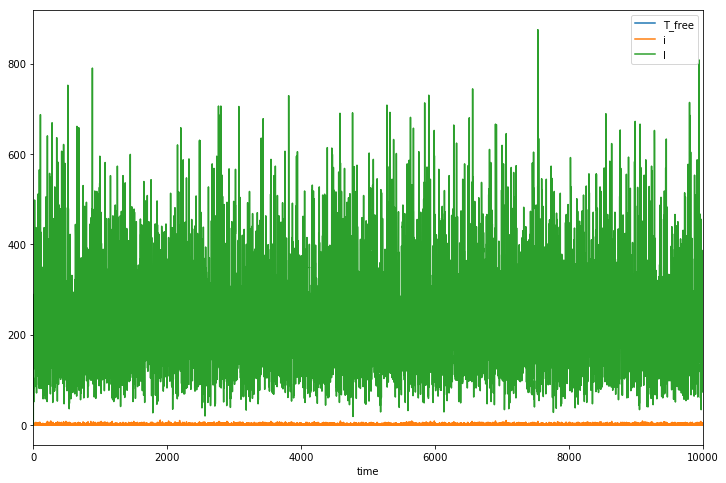

In [15]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], data)))
df.plot(x='time', y=['T_free', 'i', 'I'], kind='line', figsize=(12, 8))

In [53]:
from event_detection import event_detection

axes = (
    ('sigma_i', np.arange(0.0, 20.0 + 2.0, 2.0)),
)
print(axes)

pspace, data = simulate(system, processing=[event_detection], batchsize=10, axes=axes)

#targs, outputs = event_detection({}, system['targets'], data[0])
#print(system['targets'])
#print(targs)

(('sigma_i', array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.])),)
existing cython code is identical...
ext module version: gillespie_58 58


100%|██████████| 11/11 [02:00<00:00, 10.94s/it]


In [54]:
pspace = pd.DataFrame(pspace)

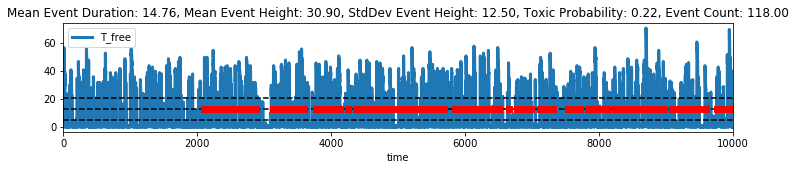

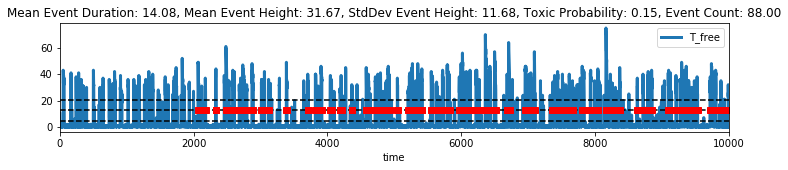

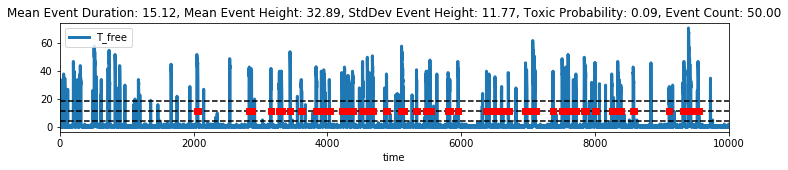

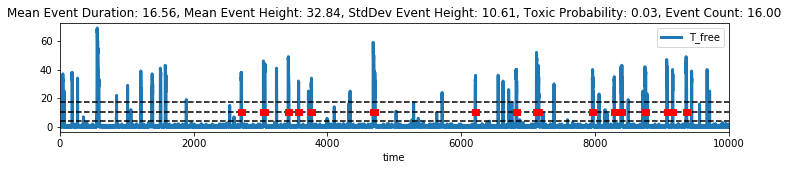

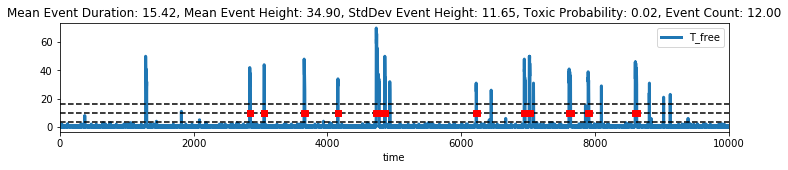

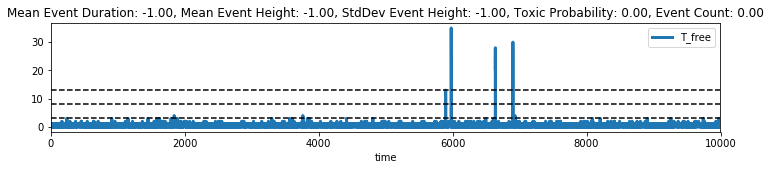

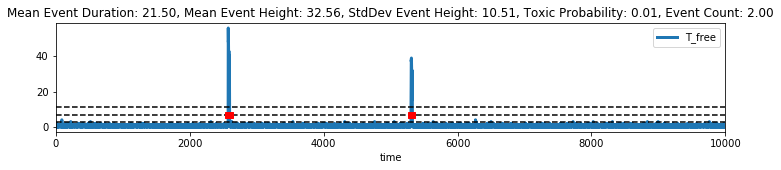

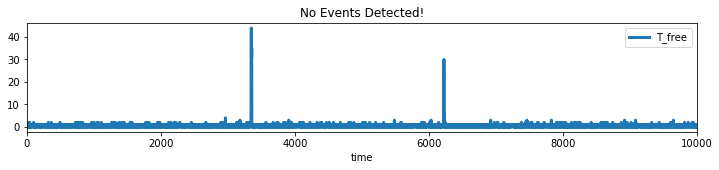

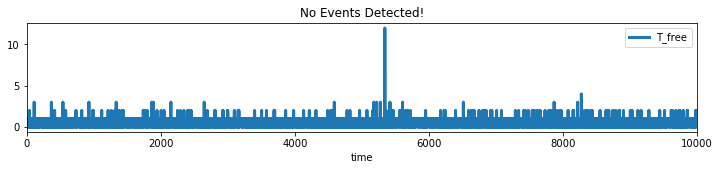

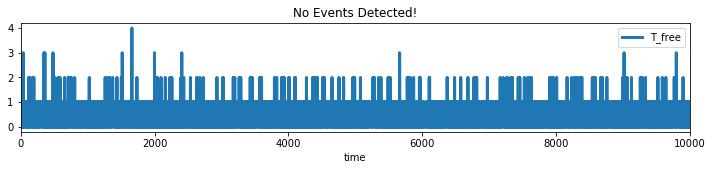

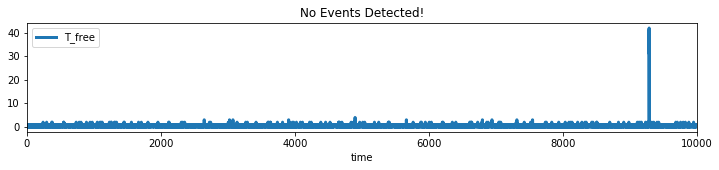

In [67]:
processing = 0
target = 'T_free'
trajectory = 0

metrics = []

target_index = system['targets'].index(target)
for l, location in pspace.iterrows():
    f, ax = plt.subplots(1, 1, figsize=(12, 2))

    outputs = data[l][processing]

    counts = outputs['batch'][trajectory, :, :]

    df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], counts)))
    df.plot(x='time', y=[target], kind='line', lw=3, ax=ax)

    measurements = pd.DataFrame(outputs['measurements'][target_index])
    
    events = outputs['events'][target_index]
    if events and sum([len(e) for e in events]):
        metrics.append(np.average(measurements, weights=measurements['Event Count'], axis=0))
        metrics[-1][-1] = measurements['Event Count'].sum()
        ax.set_title(', '.join([('%s: %0.2f' % m) for m in measurements.iloc[trajectory].items()]))
        parameters = outputs['parameters'][target_index]
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        time = counts[0, :]
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')
    else:
        metrics.append(np.array((-1, -1, -1, 0, 0)))
        ax.set_title('No Events Detected!')

pscan = pd.concat([pspace, pd.DataFrame(metrics, columns=list(measurements.keys()))], axis=1)

In [80]:
pscan.columns

Index(['sigma_i', 'Mean Event Duration', 'Mean Event Height',
       'StdDev Event Height', 'Toxic Probability', 'Event Count'],
      dtype='object')

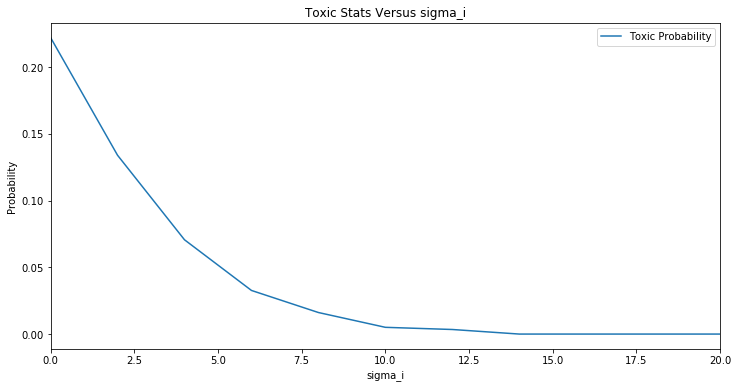

In [83]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

pscan.plot(x='sigma_i', y=[
    'Toxic Probability', 
    #'Mean Event Duration', 
    #'Mean Event Height', 
    #'StdDev Event Height', 
    #'Event Count', 
], ax=ax)
ax.set_title('Toxic Stats Versus sigma_i')
ax.set_ylabel('sigma_i')
ax.set_ylabel('Probability')